# <img style="float: left; padding: 0px 10px 0px 0px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/1920px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png"  width="80" /> MCD3100 - Ciencia de Datos Geoespaciales
**Pontificia Universidad Católica de Chile**<br>
**Magister en Ciencia de Datos**<br>

## Librerías a instalar:
Para este tutorial, se requieren las librerías PyTorch para Deep Learning y en particular Torchvision para trabajar con datasets, arquitecturas y transformaciones comunes en visión de computador.

Además, utilizaremos el paquete eeconvert para implementar transformaciones entre tipos de datos de GEE y GeoDataFrames. Si requiere instalar estas librerías, descomente y ejecute las siguientes líneas de código:

In [98]:
#!pip install torch
#!pip install torchvision
#!pip install torchsummary
#!pip install eeconvert

In [99]:
# Standard libraries
import os
import random
from tqdm.notebook import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Deep Learning libraries
import torch

import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

import geopandas as gpd
import json,geojson, ee, geemap

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Tutorial N° 14: Deep Learning para Generación de mapas LULC.


## 1. Aplicación de CNNs para la generación automática de mapas LULC.


**Créditos**: este ejercicio está basado y adaptado de [Part 2 of the Land Use and Land Cover (LULC) Mapping Tutorial](https://colab.research.google.com/drive/1Wj0LsIuotZssoQUw0QUryWk9WbOFIzV8?usp=sharing).


En la primera parte de dicho tutorial se demuestra como entrenar un modelo de aprendizaje profundo (en particular, una red neuronal convolucional o CNN) para clasificar secciones de imágenes de Sentinel 2 en distintas categorías de uso y cobertura de suelo. Para efectos de este ejercicio, partiremos de la base del modelo de visión de computador (CNN ResNet50) previamente entrenado para clasificación sobre el dataset EuroSAT.

En esta continuación, veremos cómo aplicar el modelo entrenado a nuevas regiones de interés, por ejemplo en Chile.


## 1. Importación de librerías. 

Nota: Este notebook puede ejecutarse en Google Colab o en su entorno local. En caso de utilizar Google Colab, debe montar el disco para acceder a los archivos necesarios.

In [100]:
#ee.Authenticate()
ee.Initialize()

## 2. Zona de estudio

Elegiremos como zona de estudio una comuna del sur de Chile:

<Axes: >

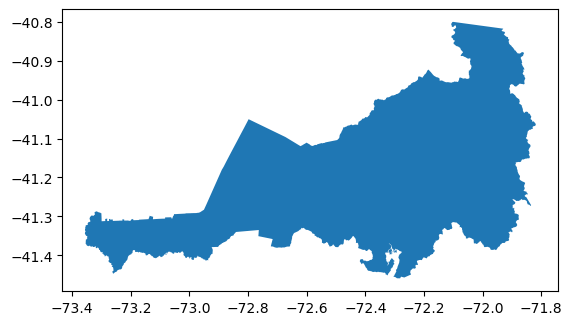

In [101]:
region=gpd.read_file('r10/COMUNA_C17.shp')
aoi=region[region['NOM_COMUNA']=='PUERTO VARAS']
aoi.plot()

In [102]:
geom = ee.Geometry.Polygon(
        [
            [
                [-73.2,-41.4],
                [-72.8,-41.4],
                [-72.8,-41.3],
                [-73.2,-41.3],
                [-73.2,-41.4],
            ]
        ]
    )
feature = ee.Feature(geom, {})

roi = feature.geometry()
centroid=(-73.5,-41.35)

## 3. Generación de imágenes Sentinel-2 

Por simplicidad, en este ejercicio utilizaremos para clasificaión sólo las bandas RGB. Sin embargo, la data multiespectral contiene información rica que puede ser de utilidad para muchas aplicaciones incluyendo clasificación de cosechas, monitoreo de la salud de la vegetación, análisis de áreas contruidas, y muchas otras tareas relacionadas con cambio climático, por ejemplo.


#### 3.1 Funciones para selección y corrección de imágenes.

Para minimizar la cobertura de nubes, generamos la mediana RGB de las imágenes con cobertura de nubes menor al 10%, sobre una ventana de tiempo.


In [103]:
def mask_s2_clouds(image):
  
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0)))

  return image.updateMask(mask).divide(10000)

#### 3.2 Selección de la imagen a clasficar.

Seleccionamos una imagen de Sentinel 2 para la región y época donde buscamos generar el mapa LULC. En este caso, nos centraremos en la comuna de Puerto Varas en el sur de Chile, y haremos el análisis para el primer trimestre del año 2025. 

Aplicamos los filtros conocidos de cobertura de nubes, corregimos por efectos de nubes y sombras, calculamos la mediana de todas las imégenes filtradas, y recortamos a la región de interés.

**NOTA**: El modelo CNN para  clasificación ha sido entrenado usando los tiles RGB del dataset EuroSAT. Por lo tanto, para realizar predicciones debe aplicar sobre la misma estructura de datos de entrada. Para generar los tiles RGB de entrada a la red neurnal, primero generamos la imagen RGB de Sentinel para toda la región de interés, usando la función [Image.visualze](https://developers.google.com/earth-engine/apidocs/ee-image-visualize). Luego, generaremos una grilla de 64x64 para recortar esta imagen RGB.

In [104]:

dataset = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate('2025-01-01', '2025-03-30').filterBounds(roi).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .map(mask_s2_clouds))

image=dataset.median().clip(roi)

visualization = {'min': 0.0,'max': 0.3,'bands': ['B4', 'B3', 'B2'],}

#Generación de la imagen RGB
image = image.visualize(bands=['B4', 'B3', 'B2'], min=0.0, max=0.3)
image

In [105]:

# Visualize map
Map = geemap.Map( zoom=16)
Map.addLayer(image, {}, 'Sentinel2')
Map.addLayerControl()
Map.centerObject(roi)
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

### 3.3 Exportar Imagen al disco local (o a GDrive).

**Nota:** la exportación de imágenes de gran tamaño puede requerir mucho tiempo y memoria, o arrojar un error. Se sugiere comenzar con una región de interés más bien pequeña, y agrandarla progresivamente en función de los recursos computacionales disponibles.

In [106]:
image = image.clip(roi).unmask()
#geemap.ee_export_image(image, filename='roi.tif', scale=10, region=roi, file_per_band=False)

### 3.4 Lectura de la imagen exportada.

Ahora podemos trabajar con la imagen en formato .tif

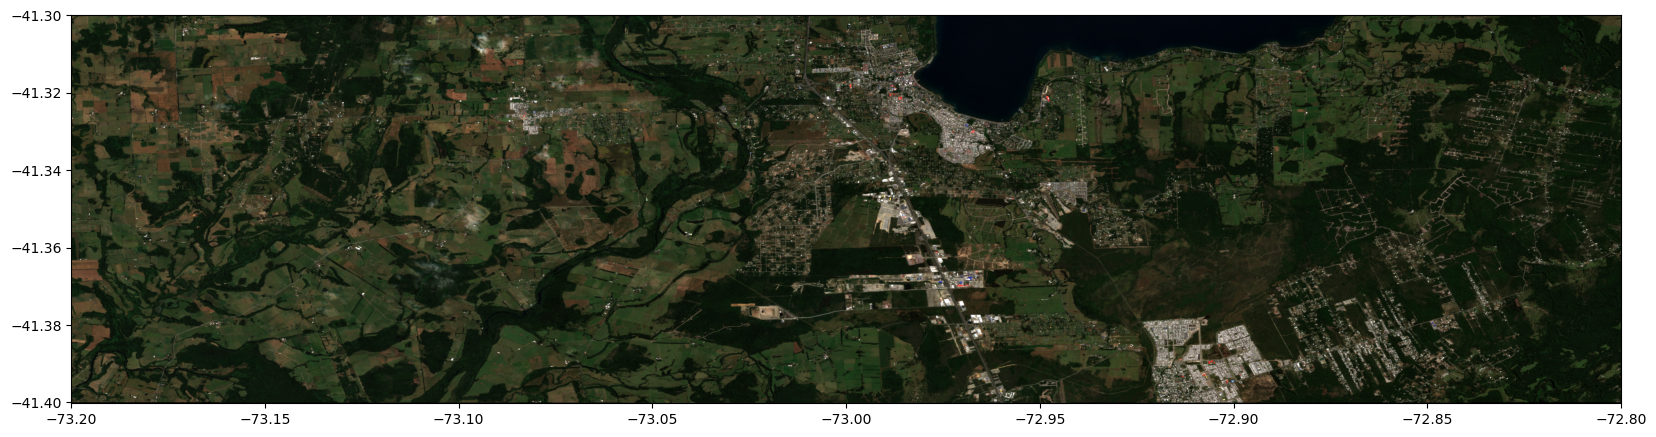

In [107]:
import rasterio as rio
from rasterio.plot import show
# Change this to your image file path
tif_file = 'roi.tif'
# Open image file using Rasterio
image = rio.open(tif_file)

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(20,10))
show(image, ax=ax);

<a name="tiles"></a>
## 4. Generación de tiles 64x64 px

El modelo CNN fue entrenado sobre el [EuroSAT RGB dataset](), que consiste de parches de imágenes Sentinel 2 de  64x64 pixeles. Por lo tanto, para aplicar el modelo debemos dividir la imagen de nuestra región de interés en parches más pequeños de 64x64 pixeles. Sentinel-2 image patches

Para esto usaremos las utilidades de [Rasterio Window](https://rasterio.readthedocs.io/en/latest/api/rasterio.windows.html).

In [108]:
from shapely import box 
def generate_tiles(image_file, output_file, area_str, size=64):
    """Generar poligonos de tiles de 64 x 64

    Args:
      image_file (str): Image file path (.tif)
      output_file (str): Output file path (.geojson)
      area_str (str): Nombre d ela region
      size(int): Tamaño de la ventana en pixeles

    Returns:
      GeoPandas DataFrame: Contiene poligonos de tiles de 64 x 64
    """

    # Abrir el raster con rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Crear un diccionario de polígonos para los tiles de 64x64 pix
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    # Barra de progreso de la creación de tiles (con tqdm)
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):
              
              # Crear ventana del tamaño size (64 pix)
              window = rio.windows.Window(h, w, size, size)
              
              # Bounds de la ventana
              bbox = rio.windows.bounds(window, raster.transform)
              
              # Creamos geometría a partir de los bounds de la ventana
              bbox = box(*bbox)

              # Creamos un id único para cada tile 
              uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

              # Actualizar diccionario
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Convertimos el diccionario a GeoGataFrame 
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # CRS: EPSG 4326
    results.crs = {'init' :'epsg:4326'}
    # Guardar como GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

In [109]:
output_file = 'tiles.geojson'
tiles = generate_tiles(tif_file, output_file, 'Puerto Varas', size=64)
print('Data dimensions: {}'.format(tiles.shape))
tiles

  0%|          | 0/4970664 [00:00<?, ?it/s]

Data dimensions: (1260, 2)


,id,geometry
0,puerto_varas-0,"POLYGON ((-73.19428 -41.3057, -73.19428 -41.29..."
1,puerto_varas-1,"POLYGON ((-73.18853 -41.3057, -73.18853 -41.29..."
2,puerto_varas-2,"POLYGON ((-73.18278 -41.3057, -73.18278 -41.29..."
3,puerto_varas-3,"POLYGON ((-73.17703 -41.3057, -73.17703 -41.29..."
4,puerto_varas-4,"POLYGON ((-73.17128 -41.3057, -73.17128 -41.29..."
...,...,...
1255,puerto_varas-1255,"POLYGON ((-72.82058 -41.40344, -72.82058 -41.3..."
1256,puerto_varas-1256,"POLYGON ((-72.81483 -41.40344, -72.81483 -41.3..."
1257,puerto_varas-1257,"POLYGON ((-72.80908 -41.40344, -72.80908 -41.3..."
1258,puerto_varas-1258,"POLYGON ((-72.80333 -41.40344, -72.80333 -41.3..."


### 4.1 Visualización de la grilla de tiles.


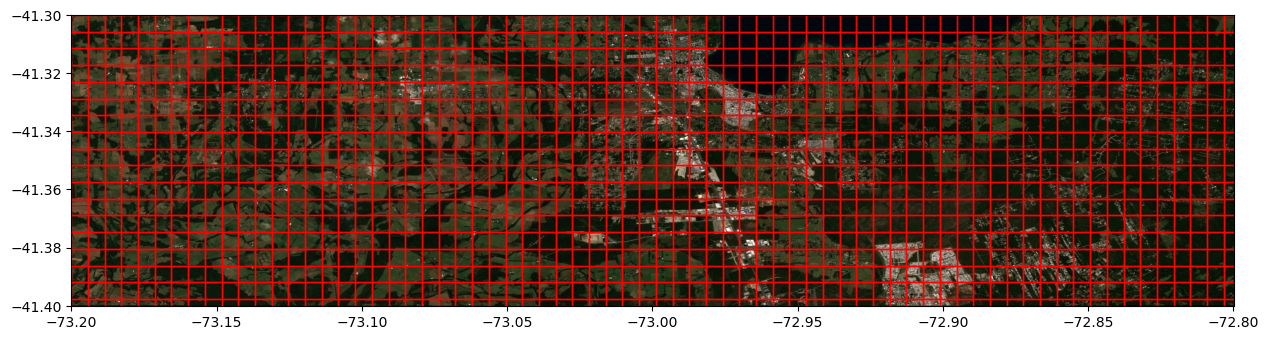

In [110]:
image = rio.open(tif_file)
fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

Si queremos filtrar los tiles con mayor detalle, podemos intersectar la grilla de tiles con otro polígono, usando la función `.sjoin()` de Geopandas. Por ejemplo, podríamos descartar los tiles que caen dentro del lago.

In [ ]:
#Geopandas sjoin function
#tiles = gpd.sjoin(tiles, boundary, op='within')


### 4.2 Visualización de un tile.

Graficamos la imagen recortada a un tile, como ejemplo.

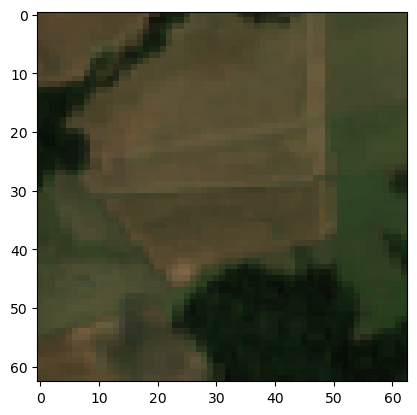

In [111]:
from rasterio.mask import mask

def show_crop(image, shape, title=''):
  """Crops an image based on the polygon shape.
  Reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

  Args:
    image (str): Image file path (.tif)
    shape (geometry): The tile with which to crop the image
    title(str): Image title
  """

  with rio.open(image) as src:
      out_image, out_transform = rio.mask.mask(src, shape, crop=True)
      # Crop out black (zero) border
      _, x_nonzero, y_nonzero = np.nonzero(out_image)
      out_image = out_image[
        :,
        np.min(x_nonzero):np.max(x_nonzero),
        np.min(y_nonzero):np.max(y_nonzero)
      ]
      # Visualize image
      show(out_image, title=title)

show_crop(tif_file, [tiles.iloc[0]['geometry']])

<a name="lulc-maps"></a>
## 5. Generación del mapa de uso de suelo.

En esta sección, generaremos nuestro mapa de clasificación de uso y cobertura del suelo utilizando el modelo entrenado del tutorial anterior. 
Recuerde que el conjunto de datos de EuroSAT consta de 10 clases LULC diferentes, como se enumeran a continuación.

In [112]:
# LULC Classes
classes = [
  'AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'
]

### 5.1 Cargar el modelo entrenado.  


In [113]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_file = 'models/best_resnet50.pth' #modelo previamente entrenado

model = models.resnet50(pretrained=True)  #Instancia de resnet
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)

#cargar los parámetros del modelo
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Modelo {} cargado exitosamente.'.format(model_file))

Modelo models/best_resnet50.pth cargado exitosamente.


En el proceso de entrenamiento de la CNN se aplicó un conjunto de transformaciones de datos a los datos de entrenamiento y prueba. Para replicar el proceso, debemos aplicar la misma transformación a las nuevas imágenes, de la siguiente manera:

In [114]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

### 5.2 Predicciones del modelo.

La siguiente función se encarga de:
- Recortar la imagen usando la geometría de los tiles de 64x64 pix
- Generar una predicción (etiqueta) para la imagen usando el modelo.


In [115]:
def predict_crop(image, shape, classes, model, show=False):
    """Generates model prediction using trained model

    Args:
      image (str): Image file path (.tiff)
      shape (geometry): The tile with which to crop the image
      classes (list): List of LULC classes

    Return
      str: Predicted label
    """

    with rio.open(image) as src:
        # Crop source image using polygon shape
        # See more information here:
        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Crop out black (zero) border
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        out_image = out_image[
          :,
          np.min(x_nonzero):np.max(x_nonzero),
          np.min(y_nonzero):np.max(y_nonzero)
        ]

        # Get the metadata of the source image and update it
        # with the width, height, and transform of the cropped image
        out_meta = src.meta
        out_meta.update({"driver": "GTiff","height": out_image.shape[1],
              "width": out_image.shape[2],"transform": out_transform})

        # Save the cropped image as a temporary TIFF file.
        temp_tif = 'temp.tif'
        with rio.open(temp_tif, "w", **out_meta) as dest:
          dest.write(out_image)

        # Open the cropped image and generated prediction
        # using the trained Pytorch model
        image = Image.open(temp_tif)
        input = transform(image)
        output = model(input.unsqueeze(0))
        _, pred = torch.max(output, 1)
        label = str(classes[int(pred[0])])

        if show:
          out_image.show(title=label)

        return label

    return None

Iteramos sobre cada tile y generamos predicciones del modelo para la imagen recortada correspondiente. Tenga en cuenta que estamos sobrescribiendo cada archivo TIFF temporal para ahorrar espacio de almacenamiento.

In [89]:

labels = [] # Store predictions

#iteración sobre tiles
for index in tqdm(range(len(tiles)), total=len(tiles)):
  label = predict_crop(tif_file, [tiles.iloc[index]['geometry']], classes, model)
  labels.append(label)

tiles['pred'] = labels

# Cleanup temporary files
!rm 'temp.tif'

# Save predictions
filepath = "PtoVaras_preds.geojson"
tiles.to_file(filepath, driver="GeoJSON")

tiles.head(3)

  0%|          | 0/1260 [00:00<?, ?it/s]

,id,geometry,pred
0,puerto_varas-0,"POLYGON ((-73.19428 -41.3057, -73.19428 -41.29...",HerbaceousVegetation
1,puerto_varas-1,"POLYGON ((-73.18853 -41.3057, -73.18853 -41.29...",HerbaceousVegetation
2,puerto_varas-2,"POLYGON ((-73.18278 -41.3057, -73.18278 -41.29...",HerbaceousVegetation


## 6. Visualizar el mapa LULC.



In [116]:
filepath = "PtoVaras_preds.geojson"
tiles = gpd.read_file(filepath)
tiles.head(3)

,id,pred,geometry
0,puerto_varas-0,HerbaceousVegetation,"POLYGON ((-73.19428 -41.3057, -73.19428 -41.29..."
1,puerto_varas-1,HerbaceousVegetation,"POLYGON ((-73.18853 -41.3057, -73.18853 -41.29..."
2,puerto_varas-2,HerbaceousVegetation,"POLYGON ((-73.18278 -41.3057, -73.18278 -41.29..."


Definimos colores para cada clase

In [117]:
import matplotlib.colors as mcolors

#Asignamos un color a cada clase.
colors = {'AnnualCrop' : 'lightgreen',
  'Forest' : 'forestgreen',
  'HerbaceousVegetation' : 'yellowgreen',
  'Highway' : 'gray',
  'Industrial' : 'red',
  'Pasture' : 'mediumseagreen',
  'PermanentCrop' : 'chartreuse',
  'Residential' : 'magenta',
  'River' : 'dodgerblue',
  'SeaLake' : 'blue'
}
tiles['color'] = tiles["pred"].apply(lambda x: mcolors.to_hex(colors.get(x)))
tiles.head(2)

,id,pred,geometry,color
0,puerto_varas-0,HerbaceousVegetation,"POLYGON ((-73.19428 -41.3057, -73.19428 -41.29...",#9acd32
1,puerto_varas-1,HerbaceousVegetation,"POLYGON ((-73.18853 -41.3057, -73.18853 -41.29...",#9acd32


In [118]:
import folium 
map = folium.Map(location=[centroid[1], centroid[0]], zoom_start=10)

folium.TileLayer(
      tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
      attr = 'Google',
      name = 'Google Satellite',
      overlay = True,
      control = True
).add_to(map)

# Agregar mapa LULCcon leyenda
legend_txt = '<span style="color: {col};">{txt}</span>'
for label, color in colors.items():

  # Colores de leyenda
  name = legend_txt.format(txt=label, col=color)
  feat_group = folium.FeatureGroup(name=name)

  # Agregar GeoJSON to feature group
  subtiles = tiles[tiles.pred==label]
  if len(subtiles) > 0:
    folium.GeoJson(
        subtiles,
        style_function=lambda feature: {
          'fillColor': feature['properties']['color'],
          'color': 'black',
          'weight': 1,
          'fillOpacity': 0.5,
        },
        name='LULC Map'
    ).add_to(feat_group)
    map.add_child(feat_group)

folium.LayerControl().add_to(map)
map

## 6. Conclusiones.

En este ejercicio, aprendimos cómo descargar una imagen satelital Sentinel-2 para una región de interés usando Google Earth Engine y aplicar un modelo CNN entrenado para generar un mapa de uso y cobertura del suelo. 

Al aplicar el modelo en una región del mundo distinta a Europa, encontraremos  que el modelo no funciona tan bien en ciertas áreas. Esto se explica a partir de las condiciones del conjunto de datos EuroSAT.

- **Categorías de escena:** Las 10 clases de cobertura terrestre en el conjunto de datos de EuroSAT no son totalmente representativas del contenido complejo de las imágenes satelitales. Estas etiquetas de clase no están mutuamente separadas (por ejemplo, una imagen puede contener tanto una carretera como una zona residencial) y su unión no cubre la distribución en el mundo real (por ejemplo, ciertos tipos de cobertura terrestre como tierras desérticas y acuicultura no están presentes en el conjunto de datos).

- **Transferibilidad limitada del modelo:** Al igual que muchos conjuntos de datos de teledetección existentes, EuroSAT, que consiste en imágenes de satélite distribuidas por toda Europa, adolece de una cobertura geográfica limitada que restringe la generalización del modelo a otras regiones del mundo. Por lo tanto, es necesaria la colaboración con diversas instituciones de investigación y mayores esfuerzos para compartir datos para mejorar la cobertura global de los conjuntos de datos anotados de teledetección.